In [1]:
from glob import glob
from pickle import load
from scipy.stats import norm
import matplotlib.pyplot as plt
from simtk import unit
import numpy as np
from tqdm import tqdm
%matplotlib inline

pkls = glob('/Users/joshuafass/Desktop/multi-collision-rate-results/*.pkl')
#pkls = glob('../data/multiple-collision-rates/*.pkl')
#pkls = glob('../data/alanine_constrained_near_eq/*.pkl')

name = "water_cluster_rigid"
#name = "alanine_constrained"

len(pkls)

544

In [2]:
summary = []
for fname in pkls:
    with open(fname, 'rb') as f:
        summary.append(load(f))

In [3]:
summary[0]

(('OVRVO',
  Quantity(value=3.0, unit=femtosecond),
  'configuration',
  'water_cluster_rigid',
  '100'),
 {'W_shads_F': array([ 0.07062217, -0.1640218 , -0.51064736, ...,  0.86550062,
          0.6029586 , -0.17265708]),
  'W_shads_R': array([ 0.36693127, -0.15205281,  1.69262809, ...,  0.39463086,
          0.41819338, -0.32959319])})

In [4]:
def get_max_conf_dt_result(scheme='VRORV'):
    max_dt = 0
    for result_ in summary:
        dt = result_[0][1].value_in_unit(unit.femtosecond)
        if (dt > max_dt) and (result_[0][0] == scheme) and (result_[0][2] == 'configuration'):
            result = result_
            max_dt = dt
    print(max_dt)
    return result

In [5]:
result = get_max_conf_dt_result()

8.0


In [6]:
result

(('VRORV',
  Quantity(value=8.0, unit=femtosecond),
  'configuration',
  'water_cluster_rigid',
  '10'),
 {'W_shads_F': array([15.21888487, 14.59357065, 10.42780726, ...,  9.85082419,
         12.46623939, 12.48623365]),
  'W_shads_R': array([18.88146238, 21.91325262, 16.0884398 , ..., 16.83450872,
         19.70882404, 15.23175273])})

In [7]:
W_F = result[1]['W_shads_F']
W_R = result[1]['W_shads_R']

In [8]:
from benchmark.evaluation import estimate_nonequilibrium_free_energy

mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
mean, np.sqrt(sq_unc)

/Users/joshuafass/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


(0.017050092935130934, 0.018679695965608763)

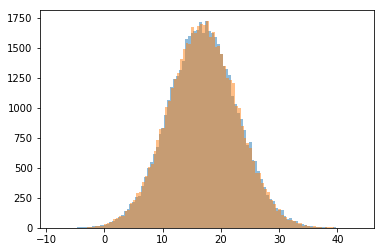

In [9]:
plt.hist(W_F, bins=100, alpha=0.5);
plt.hist(W_R, bins=100, alpha=0.5);

In [10]:
mean, np.sqrt(sq_unc)

(0.017050092935130934, 0.018679695965608763)

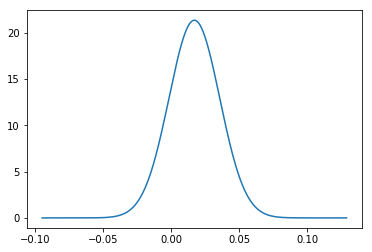

In [11]:
from scipy.stats import norm
stdev = np.sqrt(sq_unc)
n = norm(loc=mean, scale=stdev)

x_grid = np.linspace(min(0, mean - stdev * 6), mean + stdev * 6, 1000)
y_grid = np.exp(n.logpdf(x_grid))
plt.plot(x_grid, y_grid)

In [12]:
import seaborn.apionly as sns
schemes = sorted(['RVOVR', 'VRORV', 'OVRVO', 'ORVRO'])
color_schemes = dict(zip(schemes, ['Blues', 'Greens', 'Oranges', 'Purples']))

colormaps = dict()
dts = sorted(list(set([r[0][1].value_in_unit(unit.femtosecond) for r in summary])))

for scheme in schemes:
    colormap = sns.color_palette(color_schemes[scheme], n_colors=len(dts))
    colormaps[scheme] = dict(zip(dts, colormap))

dt_ = dts[int(len(dts)/2)]
colors = dict()
for scheme in schemes:
    colors[scheme] = colormaps[scheme][dt_]

In [13]:
def plot(mean, sq_unc, scheme='VRORV'):
    stdev = np.sqrt(sq_unc)
    n = norm(loc=mean, scale=stdev)

    x_grid = np.linspace(min(0, mean - stdev * 6), mean + stdev * 6, 1000)
    y_grid = np.exp(n.logpdf(x_grid))
    
    plt.plot(x_grid, y_grid, color=colors[scheme], label=scheme)

In [14]:
def nan_safe(x, y):
    """Return x, y only on indices where x[i], y[i] are both finite"""
    
    mask = np.isfinite(x) * np.isfinite(y)
    return x[mask], y[mask]

8.0
8.0
8.0
8.0


(0, 6.612000330241914)

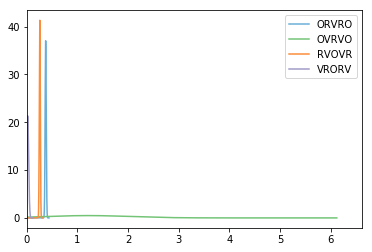

In [15]:
for scheme in schemes:
    result = get_max_conf_dt_result(scheme)
    W_F = result[1]['W_shads_F']
    W_R = result[1]['W_shads_R']
    
    W_F, W_R = nan_safe(W_F, W_R)
    
    mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
    plot(mean, sq_unc, scheme)
plt.legend(loc='best')
plt.xlim(0,)

In [17]:
def resample(x):
    return x[np.random.randint(0,len(x),len(x))]

def estimate_delta_F_using_medians(W_F, W_R):
    return 0.5 * (np.median(W_F) - np.median(W_R))

def bootstrap_median_estimates(W_F, W_R, n_bootstrap=1000):
    return np.array([estimate_delta_F_using_medians(resample(W_F), resample(W_R)) for _ in tqdm(range(n_bootstrap))])

  2%|▏         | 18/1000 [00:00<00:05, 177.49it/s]

8.0


  0%|          | 0/1000 [00:00<?, ?it/s]

8.0
8.0


  2%|▏         | 18/1000 [00:00<00:05, 176.24it/s]

8.0


100%|██████████| 1000/1000 [00:05<00:00, 180.72it/s]


(0, 1.9107744595112612)

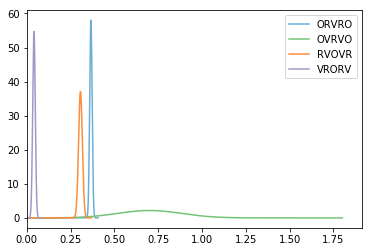

In [18]:
for scheme in schemes:
    result = get_max_conf_dt_result(scheme)
    W_F = result[1]['W_shads_F']
    W_R = result[1]['W_shads_R']
    
    W_F, W_R = nan_safe(W_F, W_R)
    
    median_estimates = bootstrap_median_estimates(W_F, W_R)
    mean, sq_unc = np.mean(median_estimates), np.std(median_estimates)**2
    #mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
    plot(mean, sq_unc, scheme)
plt.legend(loc='best')
plt.xlim(0,)

100%|██████████| 1000/1000 [00:05<00:00, 178.48it/s]


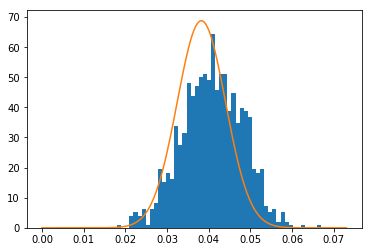

In [19]:
median_estimates = bootstrap_median_estimates(W_F, W_R)
plt.hist(median_estimates, normed=True, bins=50);
plt.plot(x_grid, y_grid)

In [18]:
collision_rates = ['0.1', '1', '10', '100']

In [21]:
summary[0]

(('OVRVO',
  Quantity(value=3.0, unit=femtosecond),
  'configuration',
  'water_cluster_rigid',
  '100'),
 {'W_shads_F': array([ 0.95716527, -0.01885348, -0.21944274, ...,  0.25395447,
          1.02026652, -0.60716308]),
  'W_shads_R': array([ 0.04146363, -0.12436154, -0.88474979, ..., -0.93365193,
         -0.62517575,  0.95027749])})

In [16]:
def get_curves_with_unc(scheme='RVOVR', marginal='configuration', collision_rate='1'):
    dts = []
    
    near_eq_estimates = []
    near_eq_unc = []
    
    for i, (descr, (result_dict)) in enumerate(summary):
        if descr[0] == scheme and descr[2] == marginal and descr[4] == collision_rate:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            
            W_F, W_R = result_dict["W_shads_F"], result_dict["W_shads_R"]
            W_F, W_R = nan_safe(W_F, W_R)
            
            mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
            
            near_eq_estimates.append(mean)
            
            near_eq_unc.append(np.sqrt(sq_unc))
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, near_eq_estimates, near_eq_unc]))

def plot_marginal(marginal='configuration', collision_rate='1', legend=True):
    plt.title(marginal)
    
    
    linestyle = {'full': 'solid',
                 'configuration': 'dotted',
                }
    
    for i, scheme in enumerate(schemes):
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal, collision_rate)
        
        plt.plot(dts, near_eq_estimates, label=scheme, linestyle=linestyle[marginal], color=colors[scheme])
        plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5, color=colors[scheme])

    
    if legend:
        plt.legend(loc='upper left', title='scheme')
    
    plt.xlabel(r'$\Delta t$ (fs)')
    
    if marginal == 'configuration':
        d_kl_arguments = r'$(\rho_\mathbf{x} \| \pi_\mathbf{x})$'
    else:
        d_kl_arguments = r'$(\rho \| \pi)$'
    plt.ylabel(r'$\mathcal{D}_{KL}$' + d_kl_arguments)

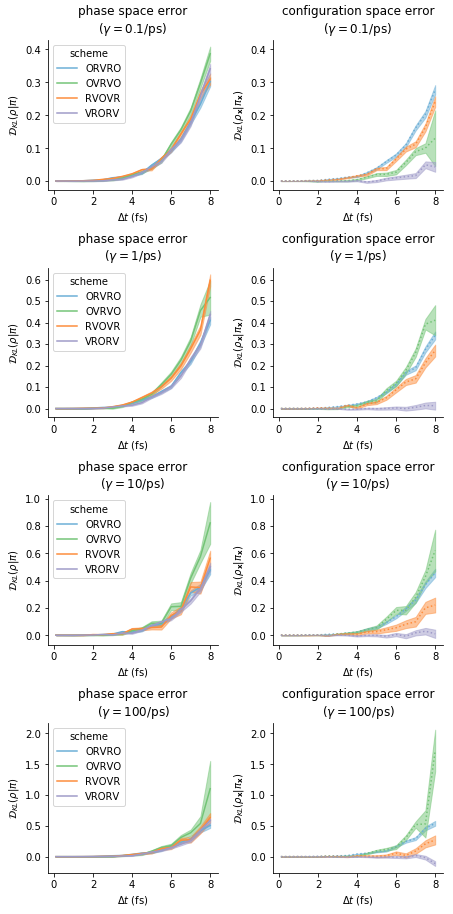

In [27]:
log = False
scale_factor = 3.2

n_rows = len(collision_rates)
n_cols = 2
ind = 1
plt.figure(figsize=(n_cols*scale_factor,n_rows*scale_factor))


for collision_rate in collision_rates:
    
    ax = None
    
    ax = plt.subplot(n_rows,n_cols,ind, sharey=ax)
    plot_marginal('full', collision_rate=collision_rate)
    plt.title('phase space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ind += 1

    if log:
        plt.yscale('log')
        plt.legend(loc='best')

    ax = plt.subplot(n_rows, n_cols, ind, sharey=ax)
    plot_marginal('configuration', collision_rate=collision_rate, legend=False)

    plt.title('configuration space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if log:
        plt.yscale('log')
        plt.legend(loc='best')
    ind += 1

#plt.ylim(0,)

plt.tight_layout()
plt.savefig('{}{}.jpg'.format(name, '_log_scale' if log else ''), dpi=300, bbox_inches='tight')

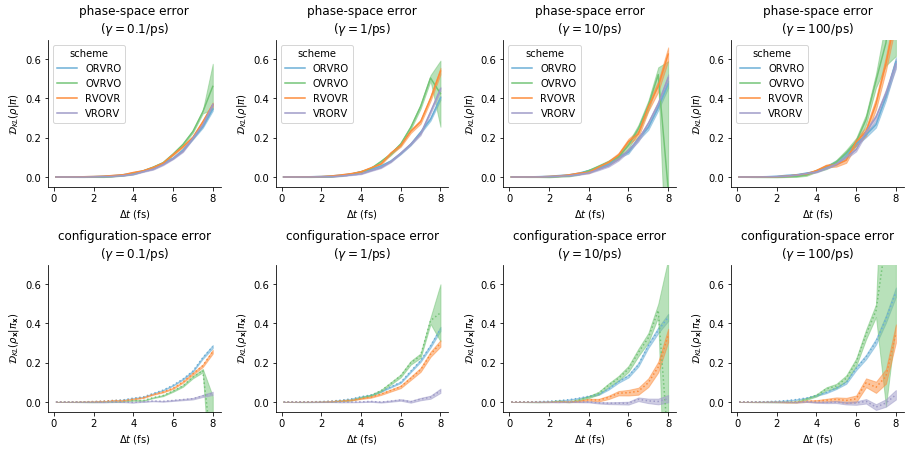

In [19]:
log = False
scale_factor = 3.2

n_rows = 2
n_cols = len(collision_rates)
ind = 1
plt.figure(figsize=(n_cols*scale_factor,n_rows*scale_factor))

ax = None
ylim = (-0.05, 0.7)
#yticks = [0, ]

for collision_rate in collision_rates:
    ax = None
    ax = plt.subplot(n_rows,n_cols,ind, sharey=ax)
    plot_marginal('full', collision_rate=collision_rate)
    plt.title('phase-space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    
    ind += 1

    if log:
        plt.yscale('log')
        plt.legend(loc='best')

for collision_rate in collision_rates:
    ax = None
    ax = plt.subplot(n_rows, n_cols, ind, sharey=ax)
    plot_marginal('configuration', collision_rate=collision_rate, legend=False)

    plt.title('configuration-space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    if log:
        plt.yscale('log')
        plt.legend(loc='best')
    ind += 1

#plt.ylim(0,)

plt.tight_layout()
plt.savefig('{}{}_multiple_collision_rates_2x.pdf'.format(name, '_log_scale' if log else ''), dpi=300, bbox_inches='tight')

In [108]:
def plot_marginal_omit_noisiest(marginal='configuration', collision_rate='1', legend=True):
    plt.title(marginal)
    
    
    linestyle = {'full': 'solid',
                 'configuration': 'dotted',
                }
    
    for i, scheme in enumerate(schemes):
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal, collision_rate)
        
        okay_inds = np.arange(len(dts))[near_eq_unc < 0.1]
        
        dts, near_eq_estimates, near_eq_unc = tuple(map(lambda array:array[okay_inds], [dts, near_eq_estimates, near_eq_unc]))
        
        plt.plot(dts, near_eq_estimates, label=scheme, linestyle=linestyle[marginal], color=colors[scheme])
        plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5, color=colors[scheme])

    
    if legend:
        plt.legend(loc='upper left', title='scheme')
    
    plt.xlabel(r'$\Delta t$ (fs)')
    
    if marginal == 'configuration':
        d_kl_arguments = r'$(\rho_\mathbf{x} \; || \; \pi_\mathbf{x})$'
    else:
        d_kl_arguments = r'$(\rho \; || \; \pi)$'
    plt.ylabel(r'$\mathcal{D}_{KL}$' + d_kl_arguments)

In [27]:
get_curves_with_unc('OVRVO','configuration', '10')[-1][-2]

0.03327156200978136

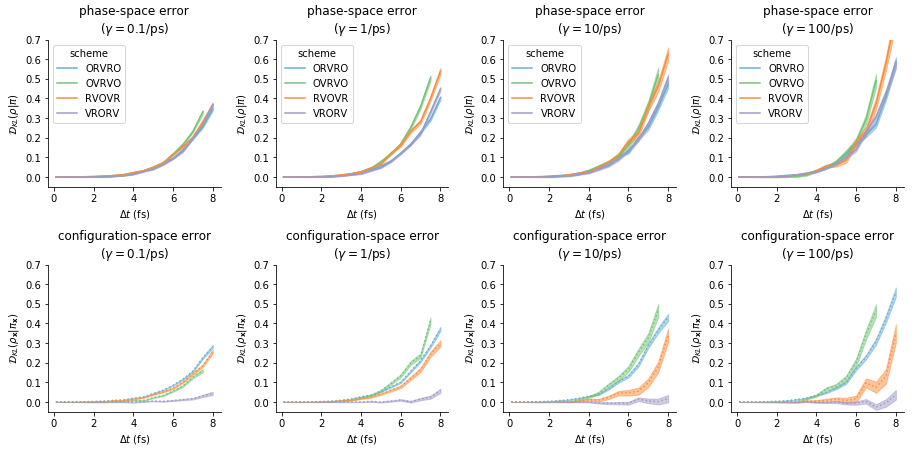

In [90]:
log = False
scale_factor = 3.2

n_rows = 2
n_cols = len(collision_rates)
ind = 1
plt.figure(figsize=(n_cols*scale_factor,n_rows*scale_factor))

ax = None
ylim = (-0.05, 0.7)
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for collision_rate in collision_rates:
    ax = None
    ax = plt.subplot(n_rows,n_cols,ind, sharey=ax)
    plot_marginal_omit_noisiest('full', collision_rate=collision_rate)
    plt.title('phase-space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    ax.set_yticks(yticks)
    
    ind += 1

    if log:
        plt.yscale('log')
        plt.legend(loc='best')

for collision_rate in collision_rates:
    ax = None
    ax = plt.subplot(n_rows, n_cols, ind, sharey=ax)
    plot_marginal_omit_noisiest('configuration', collision_rate=collision_rate, legend=False)

    plt.title('configuration-space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    ax.set_yticks(yticks)
    if log:
        plt.yscale('log')
        plt.legend(loc='best')
    ind += 1

#plt.ylim(0,)

plt.tight_layout()
plt.savefig('{}{}_multiple_collision_rates_2x.pdf'.format(name, '_log_scale' if log else ''), dpi=300, bbox_inches='tight')

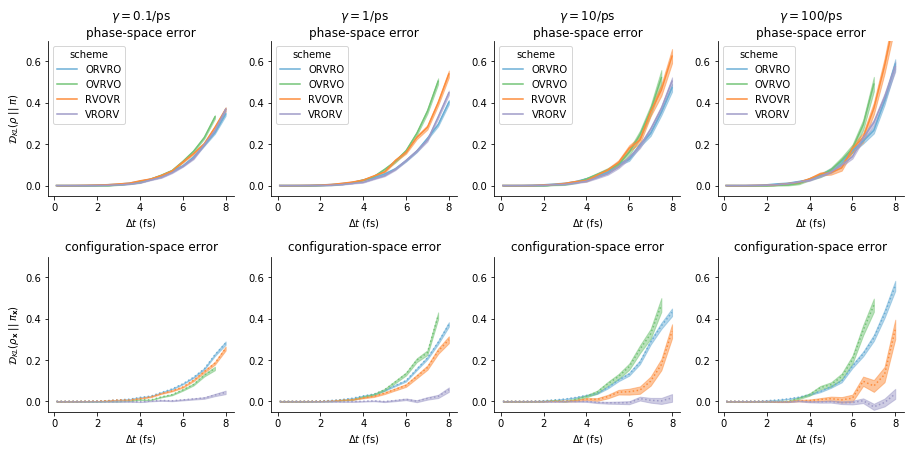

In [109]:
log = False
scale_factor = 3.2

n_rows = 2
n_cols = len(collision_rates)
ind = 1
plt.figure(figsize=(n_cols*scale_factor,n_rows*scale_factor))

ax = None
ylim = (-0.05, 0.7)
yticks = [0, 0.2, 0.4,  0.6]
for collision_rate in collision_rates:
    ax = None
    ax = plt.subplot(n_rows,n_cols,ind, sharey=ax)
    plot_marginal_omit_noisiest('full', collision_rate=collision_rate)
    plt.title(r'$\gamma=$' + '{}/ps'.format(collision_rate) + '\nphase-space error')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    ax.set_yticks(yticks)
    if ind not in [1, 5]:
        ax.set_ylabel('')
        
    
    ind += 1
    
    if log:
        plt.yscale('log')
        plt.legend(loc='best')

for collision_rate in collision_rates:
    ax = None
    ax = plt.subplot(n_rows, n_cols, ind, sharey=ax)
    plot_marginal_omit_noisiest('configuration', collision_rate=collision_rate, legend=False)
    
    plt.title('configuration-space error')#\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    ax.set_yticks(yticks)
    
    if ind not in [1, 5]:
        ax.set_ylabel('')
    
    if log:
        plt.yscale('log')
        plt.legend(loc='best')
    ind += 1

#plt.ylim(0,)

plt.tight_layout()
plt.savefig('multiple-collision-rates-grouped-by-gamma-2.jpg', dpi=300, bbox_inches='tight')

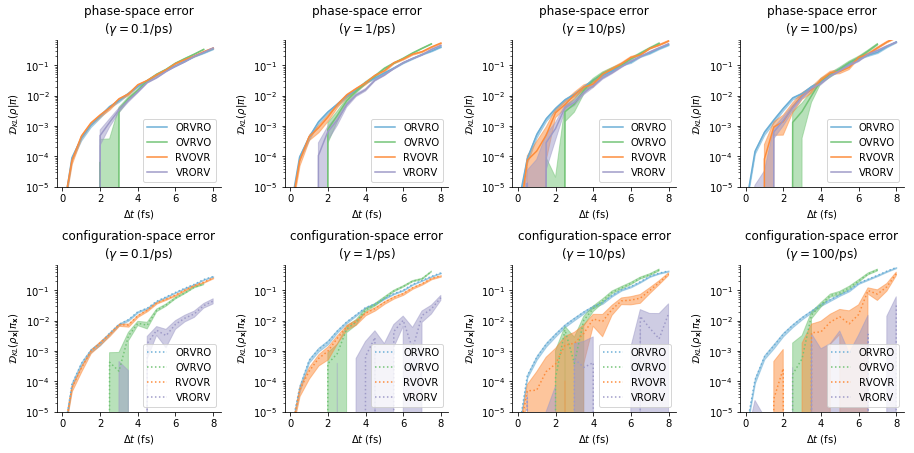

In [31]:
log = True
scale_factor = 3.2

n_rows = 2
n_cols = len(collision_rates)
ind = 1
plt.figure(figsize=(n_cols*scale_factor,n_rows*scale_factor))

ax = None
if log:
    ylim = (1e-5, 0.7)
else:
    ylim = (-0.05, 0.7)
#yticks = [0, ]

for collision_rate in collision_rates:
    ax = None
    ax = plt.subplot(n_rows,n_cols,ind, sharey=ax)
    plot_marginal_omit_noisiest('full', collision_rate=collision_rate)
    plt.title('phase-space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    
    ind += 1

    if log:
        plt.yscale('log')
        plt.legend(loc='best')

for collision_rate in collision_rates:
    ax = None
    ax = plt.subplot(n_rows, n_cols, ind, sharey=ax)
    plot_marginal_omit_noisiest('configuration', collision_rate=collision_rate, legend=False)

    plt.title('configuration-space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    if log:
        plt.yscale('log')
        plt.legend(loc='best')
    ind += 1

#plt.ylim(0,)

plt.tight_layout()
plt.savefig('{}{}_multiple_collision_rates_2x.pdf'.format(name, '_log_scale' if log else ''), dpi=300, bbox_inches='tight')

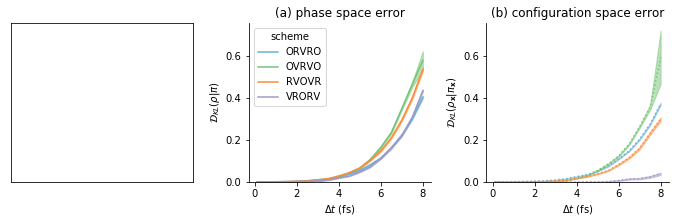

In [23]:
def get_curves_with_unc(scheme='RVOVR', marginal='configuration'):
    dts = []
    
    near_eq_estimates = []
    near_eq_unc = []
    
    for i, (descr, (result_dict)) in enumerate(summary):
        if descr[0] == scheme and descr[2] == marginal:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            
            W_F, W_R = result_dict["W_shads_F"], result_dict["W_shads_R"]
            W_F, W_R = nan_safe(W_F, W_R)
            
            mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
            
            near_eq_estimates.append(mean)
            
            near_eq_unc.append(np.sqrt(sq_unc))
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, near_eq_estimates, near_eq_unc]))

def plot_marginal(marginal='configuration', legend=True):
    plt.title(marginal)
    
    
    linestyle = {'full': 'solid',
                 'configuration': 'dotted',
                }
    
    for i, scheme in enumerate(schemes):
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal)
                
        plt.plot(dts, near_eq_estimates, label=scheme, linestyle=linestyle[marginal], color=colors[scheme])
        plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5, color=colors[scheme])

    
    if legend:
        plt.legend(loc='upper left', title='scheme')
    
    plt.xlabel(r'$\Delta t$ (fs)')
    
    if marginal == 'configuration':
        d_kl_arguments = r'$(\rho_\mathbf{x} \| \pi_\mathbf{x})$'
    else:
        d_kl_arguments = r'$(\rho \| \pi)$'
    plt.ylabel(r'$\mathcal{D}_{KL}$' + d_kl_arguments)

       
log = False
scale_factor = 3.2
plt.figure(figsize=(3*scale_factor,1*scale_factor))
ax = plt.subplot(1,3,1)
plt.plot(np.nan * np.ones(10))
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1,3,2)
plot_marginal('full')
plt.title('(a) phase space error')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if log:
    plt.yscale('log')
    plt.legend(loc='best')

ax = plt.subplot(1,3,3, sharey=ax)
plot_marginal('configuration', legend=False)

plt.title('(b) configuration space error')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
if log:
    plt.yscale('log')
    plt.legend(loc='best')

plt.ylim(0,)

plt.tight_layout()
plt.savefig('{}{}.jpg'.format(name, '_log_scale' if log else ''), dpi=300, bbox_inches='tight')

In [25]:
# what is the exponent?

[17, 17, 17, 17]


/Users/joshuafass/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:543: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


[17, 17, 17, 17]
[17, 17, 17, 17]
[17, 17, 17, 17]


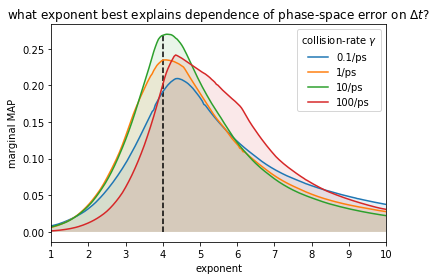

In [146]:
max_val = 0

for collision_rate in collision_rates:

    dts = np.array(dts)

    ys = []
    for scheme in schemes:
        _, near_eq_estimates, _ = get_curves_with_unc(scheme, "full", collision_rate=collision_rate)
        ys.append(near_eq_estimates)
    print([len(y) for y in ys])

    def log_prob(theta):
        coeff, exponent = theta
        if min(theta) < 0:
            return -np.inf

        model = coeff * (dts**exponent)

        log_prob = 0
        for y in ys:
            log_prob -= np.sum(np.abs(y - model))

        return log_prob

    log_prob([1e-5, 4.0])

    from scipy.optimize import fmin
    exponents = np.linspace(-1,20,num=500)
    def marginal_map(exponent):
        f_to_min = lambda coeff: -log_prob([coeff, exponent])
        xopt = fmin(f_to_min, 1, disp=0)
        return log_prob([xopt[0], exponent])

    marginal_maps = np.exp(np.array([marginal_map(exponent) for exponent in exponents]))
    
    Z = np.trapz(marginal_maps, exponents)
    
    y = marginal_maps / Z
    if max(y) > max_val:
        max_val = max(y)
    
    plt.plot(exponents, y, label=collision_rate + '/ps')
    plt.fill_between(exponents, y, alpha=0.1)
    plt.xlim(1,10)
    #plt.yscale('log')
    plt.xlabel('exponent')
    plt.ylabel('marginal MAP')

plt.vlines(4,0,max_val, linestyles='--')
plt.title('what exponent best explains dependence of phase-space error on $\Delta t$?')
plt.legend(loc='best', title='collision-rate $\gamma$')
plt.savefig('which-exponent.jpg', dpi=300, bbox_inches='tight')

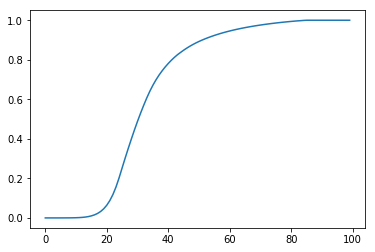

In [143]:
plt.plot(np.cumsum(marginal_maps / Z) / np.sum(marginal_maps / Z))

[17, 17, 17, 17]


/Users/joshuafass/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:543: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


[17, 17, 17, 17]
[17, 17, 17, 17]
[17, 17, 17, 17]


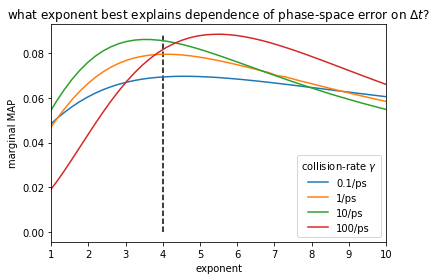

In [136]:
max_val = 0

for collision_rate in collision_rates:

    dts = np.array(dts)

    ys = []
    for scheme in schemes:
        _, near_eq_estimates, _ = get_curves_with_unc(scheme, "full", collision_rate=collision_rate)
        ys.append(near_eq_estimates)
    print([len(y) for y in ys])

    def log_prob(theta):
        coeff, exponent = theta
        if min(theta) < 0:
            return -np.inf

        model = coeff * (dts**exponent)

        log_prob = 0
        for y in ys:
            log_prob -= np.sum(np.abs(y - model)**2)

        return log_prob

    log_prob([1e-5, 4.0])

    from scipy.optimize import fmin
    exponents = np.linspace(-1,20,num=100)
    def marginal_map(exponent):
        f_to_min = lambda coeff: -log_prob([coeff, exponent])
        xopt = fmin(f_to_min, 1, disp=0)
        return log_prob([xopt[0], exponent])

    marginal_maps = np.exp(np.array([marginal_map(exponent) for exponent in exponents]))
    
    Z = np.trapz(marginal_maps, exponents)
    
    y = marginal_maps / Z
    if max(y) > max_val:
        max_val = max(y)
    
    plt.plot(exponents, y, label=collision_rate + '/ps')
    plt.xlim(1,10)
    #plt.yscale('log')
    plt.xlabel('exponent')
    plt.ylabel('marginal MAP')

plt.vlines(4,0,max_val, linestyles='--')
plt.title('what exponent best explains dependence of phase-space error on $\Delta t$?')
plt.legend(loc='best', title='collision-rate $\gamma$')
plt.savefig('which-exponent-gaussian.jpg', dpi=300, bbox_inches='tight')

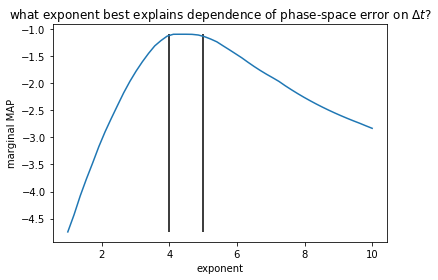

In [44]:
exponents[np.argmax(marginal_maps)]

4.3061224489795915

In [45]:
import emcee
from emcee import EnsembleSampler

mcmc = EnsembleSampler(6,2,log_prob)
_ = mcmc.run_mcmc(np.random.rand(6,2), 10000)

In [46]:
max(mcmc.flatlnprobability)

-1.0986486640067832

In [47]:
mcmc.flatchain[np.argmax(mcmc.flatlnprobability)][1]

4.2897937345134336

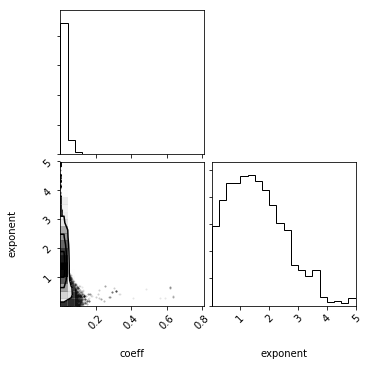

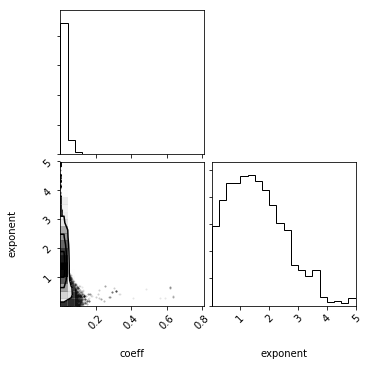

In [48]:
from corner import corner
corner(mcmc.flatchain[10000:], labels=['coeff', 'exponent'])

In [49]:
# what if we normalize by the amount of error at 2fs for ovrvo?

def plot_marginal_normalized(marginal='configuration', normalization_scheme='OVRVO', normalization_dt=2.0):
    plt.title(marginal)
    
    
    linestyle = {'full': 'solid',
                 'configuration': 'dotted',
                }
    
    
    # get error for normalization
    dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(normalization_scheme, marginal)
    normalize = near_eq_estimates[np.argmax(dts >= normalization_dt)]
    
    
    for i, scheme in enumerate(schemes):
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal)
        
        plt.plot(dts, np.abs(normalize / near_eq_estimates), label=scheme, linestyle=linestyle[marginal], color=colors[scheme])
        #plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5, color=colors[scheme])

        plt.legend(loc='upper left', title='scheme')
    
    plt.xlabel(r'$\Delta t$ (fs)')
    
    if marginal == 'configuration':
        d_kl_arguments = r'$(\rho_\mathbf{x} \| \pi_\mathbf{x})$'
    else:
        d_kl_arguments = r'$(\rho \| \pi)$'
    plt.ylabel(r'$\mathcal{D}_{KL}$' + d_kl_arguments)

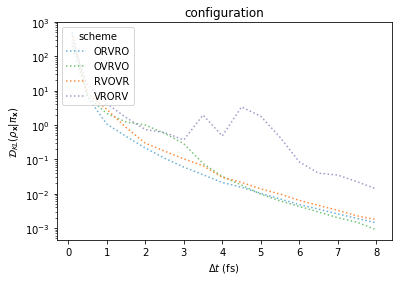

In [50]:
plot_marginal_normalized()
plt.yscale('log')

In [51]:
dts, near_eq_estimates, near_eq_unc = get_curves_with_unc("OVRVO", "configuration")
dts

array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ])

In [52]:
np.argmax(dts >= 2)

4

In [53]:
# let's save the near-equilibrium estimates
result_summary = {}
for scheme in schemes:
    result_summary[scheme] = {}
    for marginal in ['configuration', 'full']:
        result_summary[scheme][marginal] = {}
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal)
        
        keys = ('dts', 'near_eq_estimates', 'near_eq_uncertainty')
        values = (dts, near_eq_estimates, near_eq_unc)
        
        for (key, value) in zip(keys, values):
            result_summary[scheme][marginal][key] = value

In [54]:
name

'water_cluster_rigid'

In [55]:
np.save('result_summary_{}.npy'.format(name), result_summary)

In [56]:
result_summary_ = np.load('result_summary_{}.npy'.format(name))

In [57]:
from pickle import dump, load

In [58]:
with open('result_summary_{}.pkl'.format(name), 'wb') as f:
    dump(result_summary, f)

In [59]:
with open('result_summary_{}.pkl'.format(name), 'rb') as f:
    result_summary_ = load(f)

In [60]:
result_summary_['OVRVO']

{'configuration': {'dts': array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
          5.5,  6. ,  6.5,  7. ,  7.5,  8. ]),
  'near_eq_estimates': array([ -2.49269140e-06,  -7.83909400e-05,  -2.42206208e-04,
          -4.28247799e-04,  -5.26000632e-04,   9.16900556e-04,
           1.84178318e-03,   6.93290665e-03,   1.65265029e-02,
           2.95270107e-02,   5.39026827e-02,   8.47847588e-02,
           1.22533367e-01,   1.79270425e-01,   2.62454791e-01,
           3.54338155e-01,   5.92598824e-01]),
  'near_eq_uncertainty': array([  4.14009150e-07,   1.23290380e-05,   5.75001329e-05,
           1.44974005e-04,   2.81327297e-04,   4.74088847e-04,
           7.26410883e-04,   1.04881391e-03,   1.45065032e-03,
           1.92647132e-03,   2.51182041e-03,   3.18049304e-03,
           3.97991298e-03,   4.93631145e-03,   6.11336381e-03,
           1.12966400e-02,   1.27594722e-01])},
 'full': {'dts': array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  

In [61]:
0.5 * (np.mean(W_F) - np.mean(W_R)), 0.5 * (np.median(W_F) - np.median(W_R))

(0.038225087890616072, 0.041084842865095395)

In [63]:
collision_rate_colormaps = dict()
print(collision_rates)
for scheme in schemes:
    colormap = sns.color_palette(color_schemes[scheme], n_colors=len(collision_rates))
    collision_rate_colormaps[scheme] = dict(zip(collision_rates, colormap))

['0.1', '1', '10', '100']


In [112]:
def plot_marginal_by_scheme_omit_noisiest(marginal='configuration', scheme='OVRVO', legend=True):
    marginal_name = marginal
    if marginal_name == 'full':
        marginal_name = 'phase'
    
    plt.title('{marginal}-space error\n({scheme})'.format(scheme=scheme, marginal=marginal_name))
    
    
    linestyle = {'full': 'solid',
                 'configuration': 'dotted',
                }
    
    for collision_rate in collision_rates:
        label = '{} / ps'.format(collision_rate)
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal, collision_rate)
        
        okay_inds = np.arange(len(dts))[near_eq_unc < 0.1]
        
        dts, near_eq_estimates, near_eq_unc = tuple(map(lambda array:array[okay_inds], [dts, near_eq_estimates, near_eq_unc]))
        
        color = collision_rate_colormaps[scheme][collision_rate]
        plt.plot(dts, near_eq_estimates, label=label, linestyle=linestyle[marginal], color=color)
        plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5, color=color)

    
    if legend:
        plt.legend(loc='upper left', title=r'collision-rate $\gamma$')
    
    plt.xlabel(r'$\Delta t$ (fs)')
    
    if marginal == 'configuration':
        d_kl_arguments = r'$(\rho_\mathbf{x} \; || \; \pi_\mathbf{x})$'
    else:
        d_kl_arguments = r'$(\rho \; ||  \; \pi)$'
    plt.ylabel(r'$\mathcal{D}_{KL}$' + d_kl_arguments)

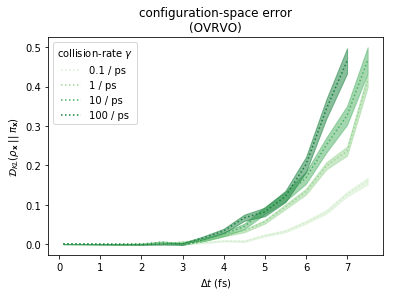

In [113]:
plot_marginal_by_scheme_omit_noisiest()

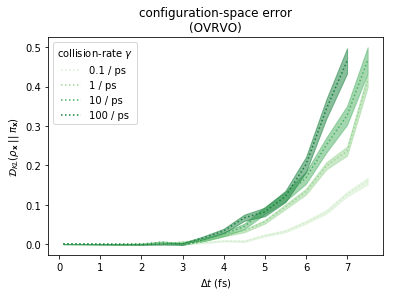

In [114]:
plot_marginal_by_scheme_omit_noisiest()

In [115]:
ylim = (-0.05, 0.7)
yticks = [0, 0.2, 0.4, 0.6]

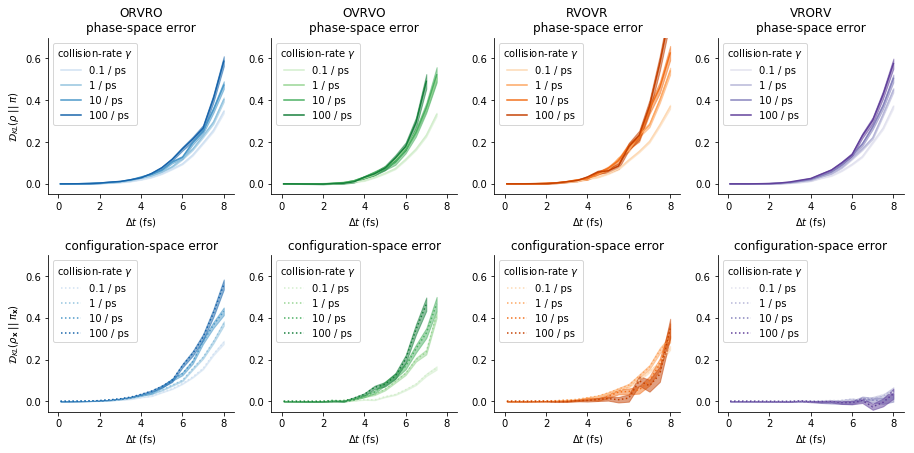

In [119]:
n_rows = 2
n_cols = len(schemes)
ind = 1

xlim = (-0.5,8.5)

plt.figure(figsize=(n_cols * 3.2, n_rows * 3.2))

for scheme in schemes:
    ax = None
    ax = plt.subplot(n_rows, n_cols, ind, sharey=ax)
    plot_marginal_by_scheme_omit_noisiest(marginal='full', scheme=scheme)

    #plt.title('configuration-space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    ax.set_yticks(yticks)
    ax.set_xlim(*xlim)
    
    ax.set_title(scheme + '\nphase-space error')
    
    if ind not in [1, 5]:
        ax.set_ylabel('')
    ind += 1


for scheme in schemes:
    ax = None
    ax = plt.subplot(n_rows, n_cols, ind, sharey=ax)
    plot_marginal_by_scheme_omit_noisiest(marginal='configuration', scheme=scheme)

    #plt.title('configuration-space error\n' + r'($\gamma=$' + '{}/ps)'.format(collision_rate))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(*ylim)
    ax.set_yticks(yticks)
    ax.set_xlim(*xlim)
    
    ax.set_title('configuration-space error')
    
    if ind not in [1, 5]:
        ax.set_ylabel('')
    ind += 1
plt.tight_layout()

plt.savefig('multiple-collision-rates-grouped-by-scheme-2.jpg', dpi=300, bbox_inches='tight')